# A quick assessment of the 2019 Polish EP election results

#### János Brezniczky
#### Last updated: 28/08/2019

## Abstract

An in development Python package [[5](#5)] will be applied to demonstrate its application as well as to depict some potential discrepancies in the 2019 European Parliament election data for Poland.

Preferential lists formed the basis of the Polish voting system during this elecetion, individual candidates comprising lists called "lista".

## Data

Not all major areas have seen candidates from each lista, and thus there are multiple data structures in the data as downloaded from the web site [[1](#1)], and there may be changes in the candidates, as well as candidate numbers.

The total (razem) column of major listas can nevertheless be concatenated into a single data frame.


In [61]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import PL.process_data as pr
from PL.preprocessing import get_preprocessed_data
import drdigit as drd
import numpy.random as rnd
from collections import OrderedDict

In [62]:
# so that things utilize each other's results
drd.set_option(physical_cache_path=".drdigit_cache")

np.random.seed(1234)

merged, info = get_preprocessed_data()

info

Merging "lista" columns...


MergedDataInfo(
    valid_votes_column: Liczba kart ważnych,
    nr_of_registered_voters_column: Liczba wyborców uprawnionych do głosowania,
    lista_columns: Lista nr 1 - KWW KONFEDERACJA KORWIN BRAUN LIROY NARODOWCY, Lista nr 2 - KW WIOSNA ROBERTA BIEDRONIA, Lista nr 3 - KKW KOALICJA EUROPEJSKA PO PSL SLD .N ZIELONI, Lista nr 4 - KW PRAWO I SPRAWIEDLIWOŚĆ, Lista nr 5 - KKW LEWICA RAZEM - RAZEM, UNIA PRACY, RSS, Lista nr 6 - KWW KUKIZ'15, Lista nr 7 - KWW POLSKA FAIR PLAY BEZPARTYJNI GWIAZDOWSKI, Lista nr 9 - KKW POLEXIT - KOALICJA, Lista nr 10 - KW JEDNOŚĆ NARODU
)

## Initial assessment

In this phase a short preparation is carried out on the country level.
The total entropy likelihood is calculated and compared to that of simulated data, giving a probability value.
To get closer to uniformity, a value filtering is applied (votes $\ge$ 100).
Since there were two listas with near-identical results, they can both be similarly often examined in this respect.

In [63]:
# to fix the smooth filtering
rnd.seed(1234)

tests = OrderedDict()

# p-values for Lista 4 filtered per ward, MIN_N_WARDS = 0
# 100: 0.0746
# 200: 0.0172
# 300: 0.0426

# minimum number of party-specific votes to require 
# per each row/each ward in a municipality
MIN_VOTE_LIMIT = 100
# minimum electoral wards to require per municipality
MIN_N_WARDS = 0
# number of simulation iterations - increase to get smoother CDFs
LL_ITERATIONS = 5000

for feasibility in ["municipality", "ward"]:
    for lista in [3, 4]:
        if feasibility == "ward":
            feasible_df = drd.get_feasible_rows(
                merged, MIN_VOTE_LIMIT,
                [list(merged.columns).index(
                    info.get_lista_column(lista))]
            )
        else:
            # I promise this filter will change :)
            groups = drd.get_feasible_groups(
                merged, min_n_wards=MIN_N_WARDS,
                min_votes=MIN_VOTE_LIMIT,
                value_colname=info.get_lista_column(lista),
                group_colname=info.area_column,
            )
            feasible_df = merged[merged[info.area_column].isin(groups)]
        
        print("Lista %d, by %s, nr of municipalities: %d" % 
              (lista, feasibility, len(feasible_df)))

        tests[(lista, feasibility)] = \
            drd.LodigeTest(
                digits=feasible_df["ld_" + info.get_lista_column(lista)],
                group_ids=feasible_df[info.area_column],
                bottom_n=20,
                avoid_inf=True,
                quiet=False,  # set to True to get rid of messages such as "0 warnings"
                ll_iterations=LL_ITERATIONS,
            )

Lista 3, by municipality, nr of municipalities: 1095
Lista 4, by municipality, nr of municipalities: 5977
Lista 3, by ward, nr of municipalities: 15994
Lista 4, by ward, nr of municipalities: 22728


In [64]:
p_values = [tests[test_id].p for test_id in sorted(tests.keys())]

test_results = pd.DataFrame(dict(Lista=[x for x, _ in tests.keys()], 
                                 Filtered_by=[x for _, x in tests.keys()],
                                 p_value=p_values))
# cokumn order
test_results = test_results[["Lista", "Filtered_by", "p_value"]]

test_results

There were 0 warnings.
There were 0 warnings.
There were 0 warnings.
There were 0 warnings.


,Lista,Filtered_by,p_value
0,3,municipality,0.5056
1,4,municipality,0.5392
2,3,ward,0.8562
3,4,ward,0.0746


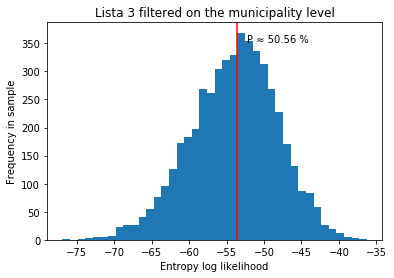

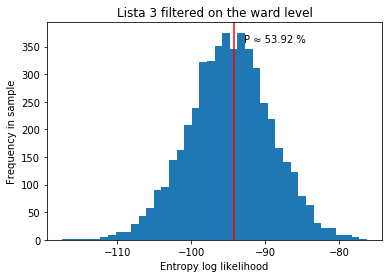

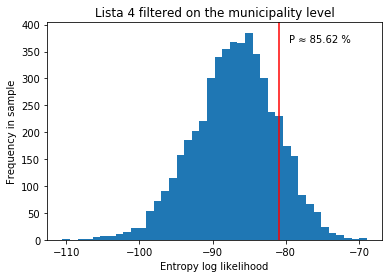

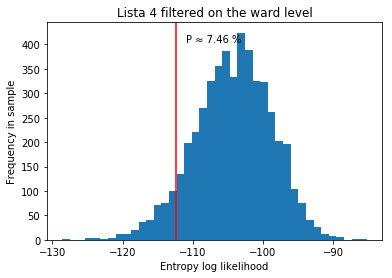

In [65]:
for lista, filtered_by in sorted(tests.keys()):
    test = tests[(lista, filtered_by)]
    drd.plot_entropy_distribution(
        actual_total_ent=test.likelihood,
        p=test.p,
        entropies=test.cdf.sample,
        title="Lista %d filtered on the %s level" % (lista, filtered_by)
    )

It suggested that per ward filtered Lista 4 result last digits are more unusual produces of a uniform distribution, when restricting to per ward votes $\ge$ 100, and (not detailed, but feel free to try it out - even less convincingly so in case of votes $\ge$ 200 or even $\ge$ 300).

This seems to be in a complementary sense with that the uniformity typically should improve as values get sufficiently large.

Also note that in case of Hungarian data [[3](#3)] this was expected to a degree, as fraud was more likely to be unavoidable for the winning party (Fidesz) to actually win in the cities there, whilst small ward counts were expected to be associable with more rural areas.

As if there was anything unusual, it seems better reflected by that one, I will use the Lista 4 results therefore as a 'driver', 'clue' for further examinations below.

## Ranking by area code

We can utilize some ranking based on a few features (relatively simple uniformity and independence statistics of last digits, see code for more details) to identify areas where records of the election results seem more irregular, perhaps doctored.

As we see below, the ranking yields diverse scores, suggesting that some degree of distinction was successfully made.

In [66]:
ranking = pr.check_ranking(merged, info)
ranking_df = pd.DataFrame({"area code": ranking.index, "score": ranking.values})

In [67]:
print(len(ranking))

ranking_df.head(10)

2478


,area code,score
0,61801,0.000000
1,140605,0.000003
2,60101,0.000005
3,302306,0.000009
4,121113,0.000016
5,280304,0.000016
6,241504,0.000035
7,240605,0.000063
8,143002,0.000098
9,200803,0.000098


In [68]:
ranking_df[1200:1210]

,area code,score
1200,20804,0.273907
1201,141701,0.275648
1202,146503,0.276177
1203,180201,0.277453
1204,121105,0.278879
1205,260605,0.278879
1206,61605,0.279457
1207,240405,0.280836
1208,261104,0.281394
1209,320903,0.281490


(array([436., 231., 206., 143., 124., 166.,  84.,  58., 138.,  62., 103.,
        109.,  73.,  66.,  12.,   9.,   8.,  25.,   6., 419.]),
 array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
        0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ]),
 <a list of 20 Patch objects>)

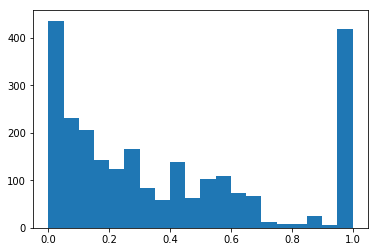

In [69]:
plt.hist(ranking, bins=20)

## Fingerprint plots

In Poland there were two major winners with relatively close results (27 vs 22 seats won [[2](#2)] ), those on Lista 3 and Lista 4. Lista 4 is a party list featuring the current ruling party, PiS. Lista 3 comprises a joint effort of the opposition, such as Platforma Obywatelska (Civic Platform).

Overall election fingerprint plots are themselves far from the impression of a joint normal distribution, the below plots show them decomposed into two halves based on the aforementioned digit irregularity ranking.

It is worth noting that as opposed to the fingerprint plots mentioned in [[4](#4)], in the present document the fingerprint plots are additionally weighted by the number of votes received by the examined lista within the wards.
This is to better depict the practical gravity of the voting situation, also the practical leverage that influencing certain wards would provide for a perpetrator.

### Lista 4

Lista 4 seems to have underperformed in the more suspicious regions.

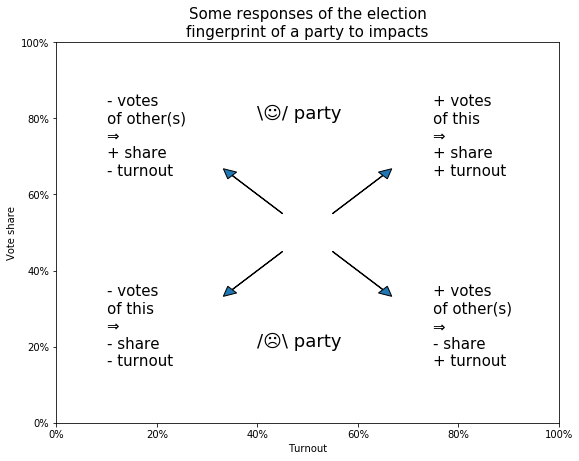

In [70]:
from drdigit import plot_explanatory_fingerprint_responses

old_size = plt.rcParams['figure.figsize']
plt.rcParams['figure.figsize'] = [9, 7]
plot_explanatory_fingerprint_responses(fontsize=15)
plt.rcParams['figure.figsize'] = old_size

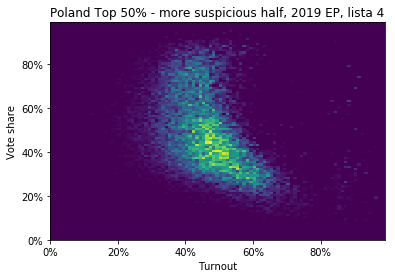

In [71]:
top_50_to = int(len(ranking) / 2)
areas = ranking.index[:top_50_to]
pr.plot_PL_fingerprint(merged, info, areas, "Top 50% - more suspicious half", 4)

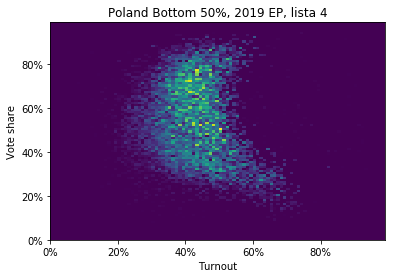

In [72]:
areas = ranking.index[top_50_to:]
pr.plot_PL_fingerprint(merged, info, areas, "Bottom 50%", 4)

### Lista 3

Lista 3 seems to exhibit a stabler and better performance in the more suspicious regions.


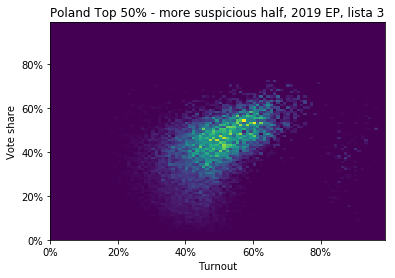

In [73]:
top_50_to = int(len(ranking) / 2)
areas = ranking.index[:top_50_to]
pr.plot_PL_fingerprint(merged, info, areas, "Top 50% - more suspicious half", 3)

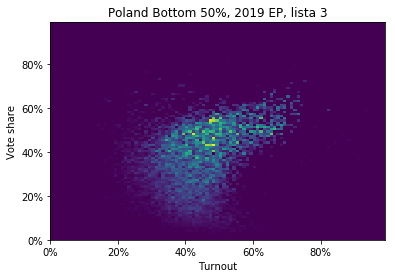

In [74]:
top_50_to = int(len(ranking) / 2)
areas = ranking.index[top_50_to:]
pr.plot_PL_fingerprint(merged, info, areas, "Bottom 50%", 3)

We can (just so that the whole thing becomes slightly less boring, and in case anyone's underdosed on old school animgifs) experiment with animations showing how the differences between the top and bottom ranked suspects appear on the charts (there's a fast rewind for now at the end).

These are admittedly extremely annoying and should be replaced by videos.

Lista 3:
<img src="fingerprints_Poland/lista 3 top 25 to bottom 25 suspects.gif"/>

Lista 4:
<img src="fingerprints_Poland/lista 4 top 25 to bottom 25 suspects.gif"/>

## Conclusion

It is just a quick exploratory analysis with certain new/under development tools, partly to illustrate the concept.

### Likely irregular last digit distribution

It was only detected when filtering for electoral wards on a per row basis, more strikingly in areas where per ward turnout reaches a higher number (100, 200, or even 300) of votes, that the last digits of Lista 4 are unlikely to come from a uniform distribution.

### Consistent change

There is some consistent change in the vote rates obtained by the parties as we move towards more suspect areas, particularly in the performance of Lista 3 and Lista 4. Lista 3 obtaining a higher, Lista 4 achieving a lower rate, both apparently more consistently (vertical deviation seems to reduce), and at the same time underlined by higher turnout.

### Explanations

#### A possible confounder

Of course it is not necessarily the point at which everyone should cry "fraud". It could happen, beyond doubtful "matter of chance" explanations, for instance, that in rural areas the vote counting is taken with less rigour, which can then imply that where certain vote counts are naturally higher or lower, we observe traces of discrepancies.

This could also be accelerated by, for example, some ranking statistic being unexpectedly sensitive towards the number of ballots.

There of course can easily be more numerous confounders.

#### Other hypothetical options

However, this is also consistent with what was experienced (so far) with the Hungarian data - and which could also be temptingly easily explained by "virtual ballot stuffing": a systematic doctoring of the recorded numbers in order to increase/decrease the final results of certain parties at the price of an increased number of overall votes (and therefore, turnout rate).

Ballot stuffing generally is expected to leave "smearing" traces [[4](#4)] on fingerprint charts, this might also be something we can observe - this would suggest that two 'forces' would have tried to rig one election in ways countering each other's efforts, since both the Lista 3 and Lista 4 fingerprints are smeared towards the top right hand corner, Lista 4 also being smeared towards the bottom right hand corner, apperently more so in case of the more suspicious areas.

#### Quality

Perhaps some increased degree of quality assurance would be desirable in Poland as well, of course the author is even less entitled to judge on that than in case of Hungary.

However, beside numerous further explanations, it might be that the package is simply bogus - testing, contribution are welcome.

The primary conclusion is that the election data seems to be worth a more elaborate look.

## References

<a id="1"></a>
[1] The election data was downloaded from the [Polish election website](https://wybory.gov.pl/pe2019/)

<a id="2"></a>
[2] [2019 European Parliament election in Poland, Wikipedia](https://en.wikipedia.org/wiki/2019_European_Parliament_election_in_Poland)

<a id="3"></a>
[3] The Hungarian analysis is under development [here](https://nbviewer.jupyter.org/github/brezniczky/ep_elections_2019_hun/blob/master/report.ipynb)

<a id="4"></a>
[4] [Forensic analysis of Turkish elections in 2017–2018](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0204975)

<a id="5"></a>
[5] The package is currently under development [in this GitHub repository](https://github.com/brezniczky/drdigit)

<a id="6"></a>
[5] This document is hosted [in this GitHub repository](https://github.com/brezniczky/ep_elections_2019_hun)
